# Kriging for regression

Hi everyone, welcome to the notebook for Kriging process for Regression, part of the assignment for the course CEGM2003. Two types of kriging are evaluated, ordinary kriging and simple kriging. Afterwards, both methods are validated and compared to gaussian processes to see which method performs best while interpolating on unseen data. See [Full Project Description](https://surfdrive.surf.nl/files/index.php/s/HVIy8Y2Yg6mLorB/download?path=%2F&files=GEOSPATIAL__Exploring%20the%20effect%20of%20different%20formulations%20of%20Gaussian%20processes%20on%20spatial%20predictions.pdf) for more details on this. 

Data is visualized in order to understand the underlying processes. The hyperparameter optimization is done by fitting the best hyperparameter model (kernel) onto the variogram, based on multiple parameters using kfold cross validation for both kriging methods. Ultimately, the goals is to choose the model that achieves the smallest loss, indicating the best performance. Finally, plots can be made that allow for comparison of validation loss between different kernels.

The success of kriging relies significantly on the definition of a mean function and a covariance function. The prediction method entails estimating values at unobserved locations through the solution of a system of linear equations. The weights in these equations are determined by considering the spatial correlation between different locations. This spatial correlation is established by fitting a model, often referred to as a kernel, onto the variogram. Several kriging methods exist, each with its unique approach. In this notebook, a detailed explanation will be provided for two specific kriging methods: simple kriging and ordinary kriging. 

These methods employ distinct strategies in terms of mean estimation and covariance modeling, contributing to their effectiveness in spatial prediction tasks. Some key aspects that will be discussed are the fitting of the variogram and solving the least square estimation in further detail. Also some insights into these methods will be explored in subsequent sections of the notebook.


In [ ]:
%matplotlib inline
!pip install pykrige
!pip install gstools
!pip install scikit_gstat


import warnings
warnings.simplefilter("ignore")

# Import all the required libraries
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
import copy
from prettytable import PrettyTable

# import necessary packages

from pykrige import OrdinaryKriging
from gstools import Gaussian, krige, Exponential, Spherical, CovModel, vario_estimate
from skgstat import Variogram
from sklearn.model_selection import train_test_split

from cycler import cycler
from helper_functions import *

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

# Set a fixed seed, needed for reproduction of the results 
seed = 0
np.random.seed(seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.4/864.4 kB 49.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 24.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.3/708.3 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 117.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43

## Loading and preparing data 

The [data](https://www.sciencebase.gov/catalog/item/5fbbf574d34eb413d5e2553a) is a set of contaminated sites of boreholes in the United States and links to this [paper](https://ngwa.onlinelibrary.wiley.com/doi/10.1111/gwat.13081). This exercise uses only data from borehole 94-BR, and the goal is to predict the [Total Volatile Organic Compounds](https://www.dcceew.gov.au/environment/protection/npi/substances/fact-sheets/total-volatile-organic-compounds) (TVOC) [-] from depth [m]. In this section the dataset is loaded and prepared in order to explore it. 


In [ ]:
#Read the data from the provided csv file
data = pd.read_csv('contaminated-sites_dataset.csv', sep=',', header=0)

#Select well
data = data.loc[data['WELL_ID'] == '94-BR']

#Prepare the data by selecting the right columns, getting rid of NaN values and normalizing
TVOC = data.iloc[:,8]
depth = data.iloc[:,7]

TVOC_cleaned = TVOC[~np.isnan(TVOC)]
depth_cleaned = depth[~np.isnan(TVOC)]

After filtering the NaN values out of the data, a histogram was plotted to look at the distribution of the data.

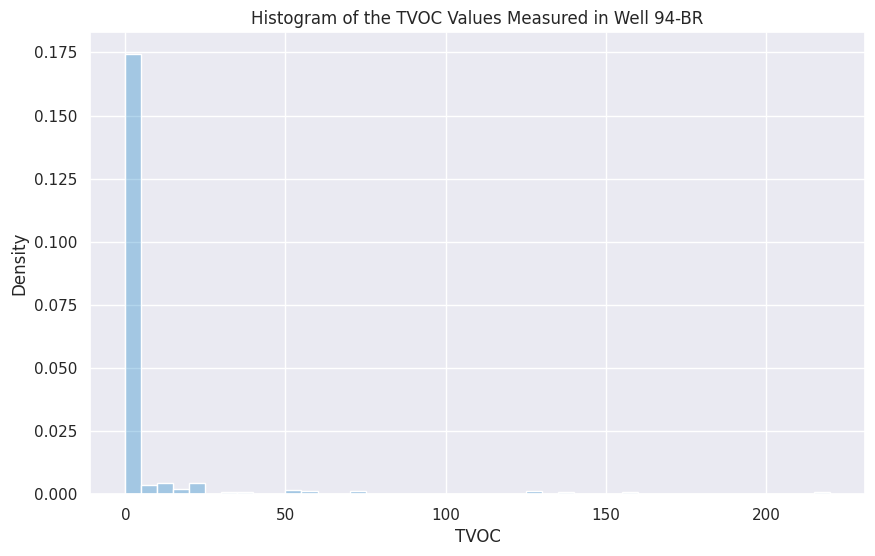

In [ ]:
#Plot the original data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
TVOC_pd = pd.DataFrame(TVOC_cleaned)


sns.histplot(data=TVOC_pd, x=TVOC_cleaned,alpha=0.3, binwidth=5,stat='density', log_scale=False, kde=False)
plt.title('Histogram of the TVOC Values Measured in Well 94-BR');

As can be seen, the data is heavily skewed to one side. To get a better distribution of the data for the algorithm, the logarithm of the TVOC values was taken. Resulting in the following figure.

In [ ]:
#Log-transform TVOC-data
TVOC_log = np.log(TVOC_cleaned)

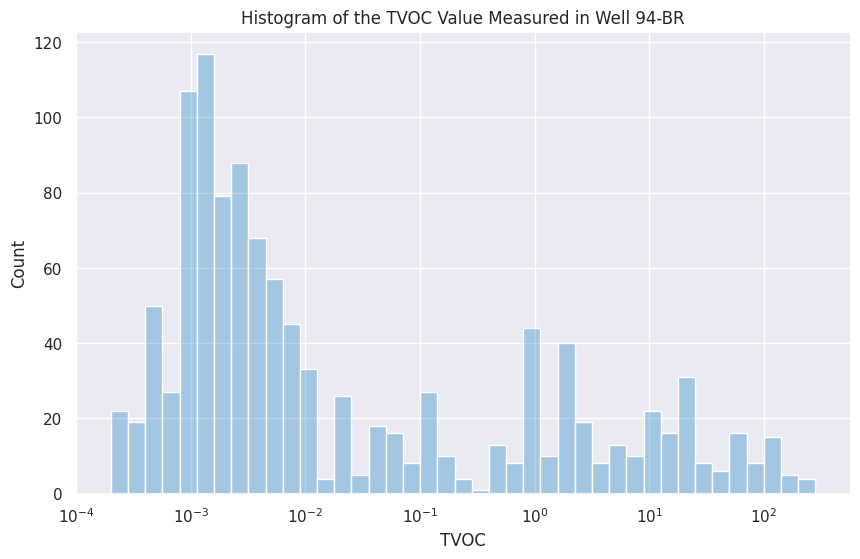

In [ ]:
# Plot a histogram for the TVOC values in well 94-BR
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
TVOC_pd_log = pd.DataFrame(TVOC_log)

sns.histplot(data=TVOC_pd_log, x=TVOC_cleaned,alpha=0.3, binwidth=0.15, log_scale=True, kde=False)
plt.title('Histogram of the TVOC Value Measured in Well 94-BR');

Now that the data has been scaled appriopriately, the data can be plotted as measured in real life, namely depth on the vertical axis and TVOC value on the horizontal axis. This represents how these values are obtained along the depth of the well. Both the non-lognormalized graph and the lognormalized graph are plotted.

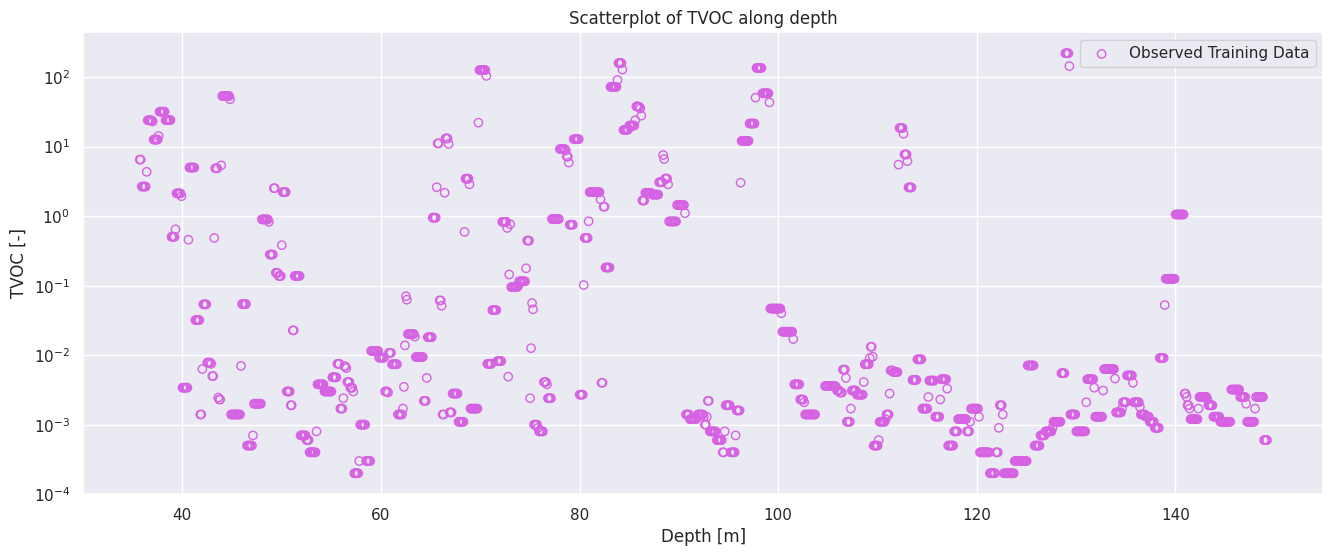

In [ ]:
#Plot the data
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

#Plot the data without normalization
ax.scatter(depth_cleaned,TVOC_cleaned, facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax.set_yscale('log')
ax.set_title('Scatterplot of TVOC along depth')
ax.set_ylabel('TVOC [-]')
ax.set_xlabel('Depth [m]')
ax.legend();

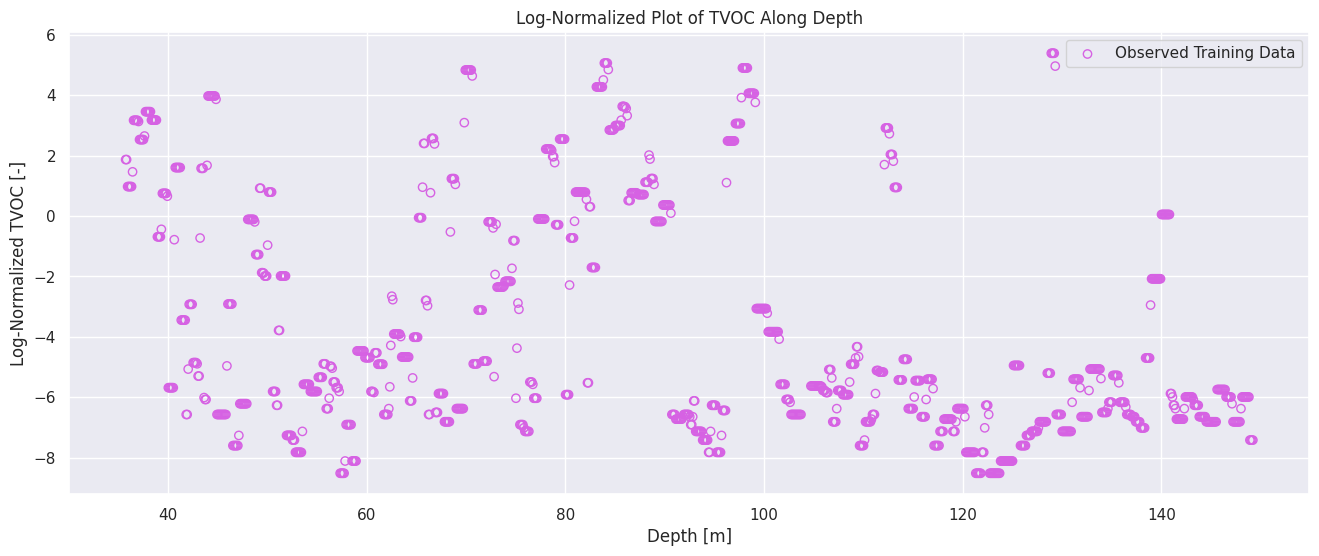

In [ ]:
#Plot the data
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

#Plot the log-normalized data
ax.scatter(depth_cleaned, TVOC_log, facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax.set_title('Log-Normalized Plot of TVOC Along Depth')
ax.set_ylabel('Log-Normalized TVOC [-]')
ax.set_xlabel('Depth [m]')
ax.legend();

As can be seen, the data varies considerably and has certain peaks on locations where high TVOC values were measured. It is questioned whether or not the kriging algorithm or gaussian processes would be better able to capture these small variations in the spatial variability. Two kriging algorithms were selected to later compare to gaussian processes. Ordinary kriging, that only looks at a specified n_closest points while interpolating and simple kriging that looks at the entire dataset.

# Ordinary Kriging

Ordinary kriging is a specific interpolation technique that has some assumptions. On of its assumptious is that that it assumes second order stationarity. Furthermore, the covariance function and mean remain constant  throughout the spatial domain, which is seen below:

Stationarity Formula:
$$
\begin{aligned}
& m(x)=\mu \\
& k\left(x, x^{\prime}\right)=C
\end{aligned}
$$

Here, $m(x)$ is the mean function, $\mu$ is the global mean, $k\left(x, x^{\prime}\right)$ is the covariance function, and $C$ is a constant.

The mean function represents a global mean, which is constant for all locations. The covariance function indicates that the spatial correlation between any two points depends only on the distance between them, not on their specific locations.

First it was tested if both algorithms were working correctly. The entire dataset was provided to the algorithm to see how the predictions and the confidence region behaved.

For the ordinary kriging algorithm to work, a variogram model had to be specified and the number of lags related to the number of bins. These both were taken into account as hyperparameters for the optimization process. Here for now a 'spherical' variogram was chosen and nlags was put at 100.

In [ ]:
# Call the Ordinary Kriging function
ok = OrdinaryKriging(depth_cleaned,
                     np.zeros(len(depth_cleaned)), # 1D so y is array of zeros
                     TVOC_log,
                     variogram_model='spherical', # Variogram option
                     nlags = 100,
                     verbose=True)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 6.840715051590635
Full Sill: 15.237371804156359
Range: 27.81777298331837
Nugget: 8.396656752565724 

Calculating statistics on variogram model fit...


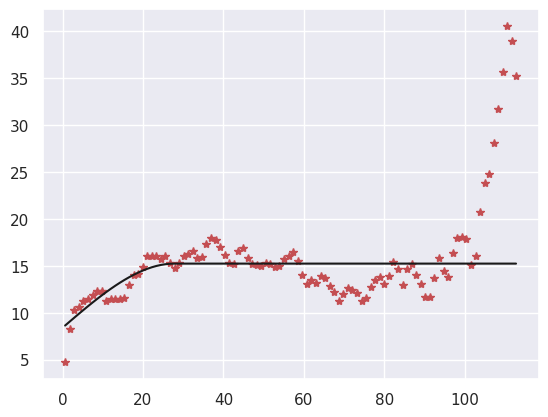

In [ ]:
#Display the variogram of Ordinary Kriging
ok.display_variogram_model()

As can be seen, the range of the variogram is about 28 meters, meaning that measures further than that are not collaborating on the interpolation value of a point. The nugget is quite high, 8.4 meter, indicating that the measurements are very variable and seemingly noisy, which is likely due to the quick high jumps in values.





## Solve system of equations

The covariance matrix $(C)$ is constructed based on the variogram model fitted to the data. The covariance matrix as well as the vector of semivariances between unsamples location and each sampled lcation also called proximitry matrix will be build. This allows for the system of equations to be solved for ordinary kriging, which is expressed as:



The system of equations to be solved for Ordinary Kriging can be expressed as:
$$
C \cdot \lambda=\gamma
$$

- $C$ is the covariance matrix.
- $\lambda$ is a vector of Lagrange multipliers or kriging weights.
- $\gamma$ is the proximity matrix

The system of equations is typically expressed in matrix form:
$$
\left[\begin{array}{cccc}
C_{11} & C_{12} & \ldots & C_{1 n} \\
C_{21} & C_{22} & \ldots & C_{2 n} \\
\vdots & \vdots & \ddots & \vdots \\
C_{n 1} & C_{n 2} & \ldots & C_{n n}
\end{array}\right]\left[\begin{array}{c}
\lambda_1 \\
\lambda_2 \\
\vdots \\
\lambda_n
\end{array}\right]=\left[\begin{array}{c}
C\left(h_1\right) \\
C\left(h_2\right) \\
\vdots \\
C\left(h_n\right)
\end{array}\right]
$$

Once the system is solved, the kriging weights $(\lambda)$ are obtained. These weights determine the contribution of each sampled point to the estimation at the unsampled location.


The estimated value $\left(\hat{Z}_0\right)$ at the unsampled location is then given by the kriging formula:
$$
\hat{Z}_0=\sum_{i=1}^n \lambda_i Z_i
$$
where $Z_i$ is the observed value at sampled location $x_i$, and $\lambda_i$ is the corresponding kriging weight. This will be applied 

 Below a prediction was made on a specified grid to visualize how the algorithm performs. Here, another hyperparameter had to be specified, namely the n_closest points. This specifies a local window to take into account during interpolation. For now, a value of 25 was chosen.

In [ ]:
# Define where to predict along depth
x_pred_depth = np.linspace(35, 149, 115)

# Interpolate values with execute function, n_closest_points chosen as 25
# with nbins = 50, one bin equals 2 m domain size, 2 * 25 = 50 m, equals
# half of domain,  which was advised
TVOC_pred_log_ordinary, TVOC_var_log_ordinary = ok.execute('grid', x_pred_depth, 0, backend='loop', n_closest_points = 25)
TVOC_pred_log_ordinary = np.squeeze(TVOC_pred_log_ordinary)
TVOC_var_log_ordinary = np.squeeze(TVOC_var_log_ordinary)

Executing Ordinary Kriging...



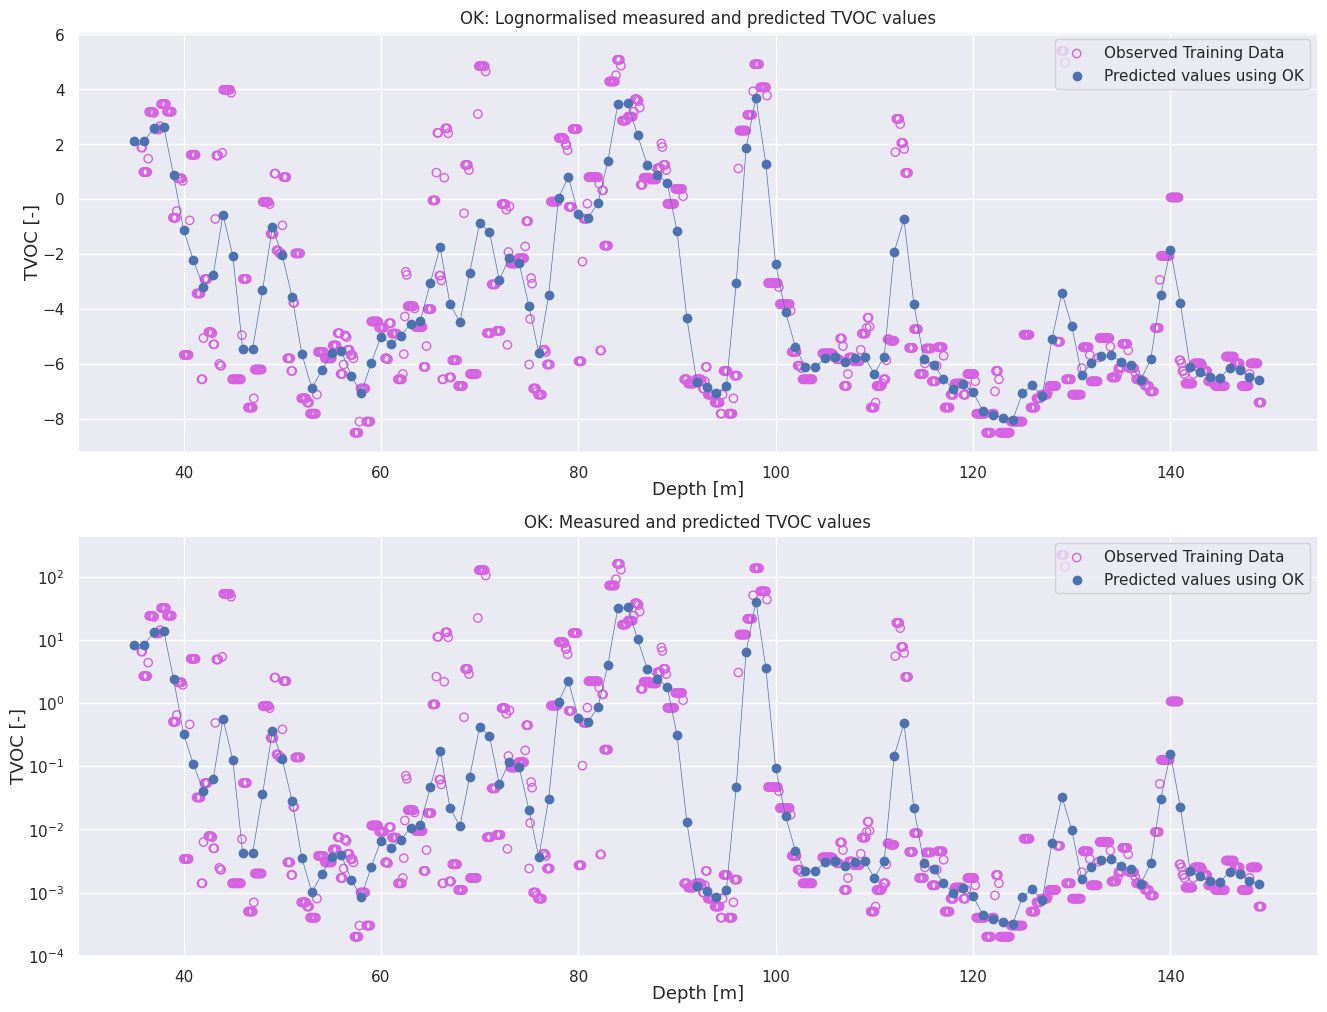

In [ ]:
#Plot the predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot the measured and predicted values in the lognormalized state
ax1.scatter(depth_cleaned, TVOC_log, facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax1.scatter(x_pred_depth,TVOC_pred_log_ordinary , label='Predicted values using OK', c='b')
ax1.plot(x_pred_depth,TVOC_pred_log_ordinary ,'b-', lw=0.5)

#facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data"

ax1.set_title('OK: Lognormalised measured and predicted TVOC values')
ax1.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax1.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax1.legend(loc='upper right');

# De-normalize by using e
TVOC_pred_ordinary = np.exp(TVOC_pred_log_ordinary)
TVOC = np.exp(TVOC_log)

# Plot the measured and predicted values in the de-normalized state
ax2.scatter(depth_cleaned,TVOC , facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax2.scatter(x_pred_depth,TVOC_pred_ordinary , label='Predicted values using OK', c='b')
ax2.plot(x_pred_depth,TVOC_pred_ordinary,'b-', lw=0.5)

ax2.set_yscale('log')
ax2.set_title('OK: Measured and predicted TVOC values')
ax2.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax2.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax2.legend(loc='upper right');

As can be seen, the algorithm performs quite well, following the shape of the data and generally follows where peaks are present. This is likely due to the moving window specified with n_closest points.

# Simple Kriging

For the simple kriging algorithm the same is done as before with ordinary kriging. However, simple kriging works slightly different. This is because some underlying assumptions are that the expected mean is 0 for the entire dataset and that the covariance matrix is known. This makes the model less flexible, but can be benificial if we can expect for the data to be globally statistically the same. 

Here, it was necessary to first make the variogram itself before feeding it to the simple kriging algorithm. Here a spherical variogram was used, indicating that different types of model fits are a hyperparameter for the simple kriging algorithm. This was used later for the optimization. Below the variogram is plotted.

The variogram model fitted to the data is:
Spherical(dim=1, var=6.43, len_scale=26.3, nugget=8.43)


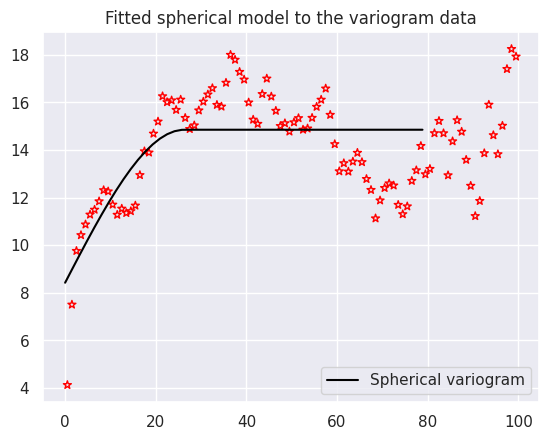

In [ ]:
#Specify the values used for computing the variogram
cond_pos = depth_cleaned.values
cond_val = TVOC_log.values

#Simple Kriging variogram analysis, single spherical variogram
V = Variogram(cond_pos, cond_val, n_lags=100, maxlag=100, model='spherical')

#Bin the calculated values
bin_center, gamma = V.get_empirical(bin_center=True)

#Fit a spherical model to the binned values
fit_model = Spherical(dim=1, var=np.std(TVOC_log)**2)
fit_model.fit_variogram(bin_center, gamma)
print('The variogram model fitted to the data is:')
print(fit_model)

#Plot the fitted variogram
ax = fit_model.plot(color='black')
ax.set_title('Fitted spherical model to the variogram data')
#ax.set_xlabel('Distance', fontsize=13, labelpad=0)
#ax.set_ylabel('Semi-variance', fontsize=13, labelpad=0)
ax.scatter(bin_center, gamma, facecolors='none', edgecolors='red', marker='*');

As can be seen this results in a similar variogram as plotted by the ordinary kriging package.

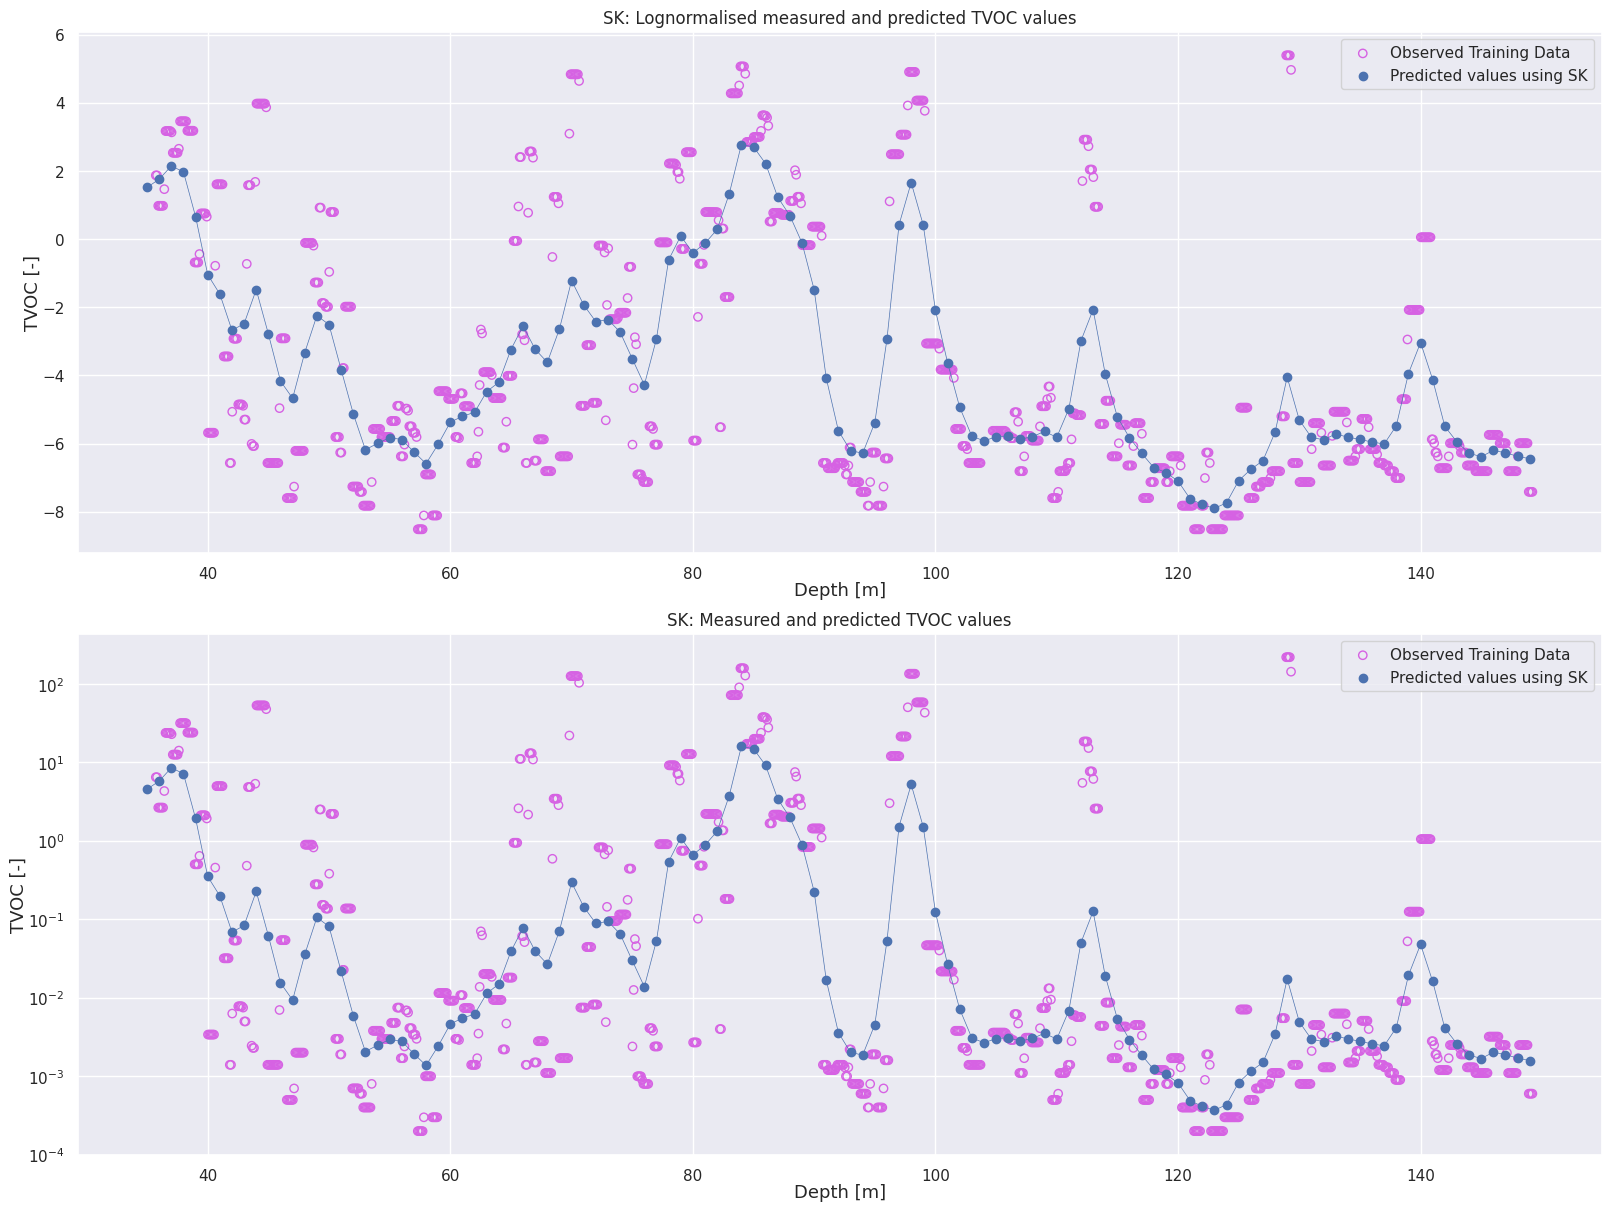

In [ ]:
#Use the simple kriging algorithm
krig = krige.Simple(fit_model, mean=np.mean(cond_val), cond_pos=cond_pos, cond_val=cond_val)

TVOC_pred_log_simple, TVOC_var_log_simple = krig(x_pred_depth)
TVOC_mean_log_simple = krig(x_pred_depth, only_mean=True)

#Plot the predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), constrained_layout=True)

# Plot the measured and predicted values in the lognormalized state
ax1.scatter(depth_cleaned,TVOC_log , facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax1.scatter(x_pred_depth,TVOC_pred_log_simple , label='Predicted values using SK', c='b')
ax1.plot(x_pred_depth,TVOC_pred_log_simple ,'b-', lw=0.5)

ax1.set_title('SK: Lognormalised measured and predicted TVOC values')
ax1.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax1.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax1.legend(loc='upper right');

# De-normalize by using e
TVOC_pred_simple = np.exp(TVOC_pred_log_simple)
TVOC = np.exp(TVOC_log)

# Plot the measured and predicted values in the de-normalized state
ax2.scatter(depth_cleaned,TVOC , facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax2.scatter(x_pred_depth,TVOC_pred_simple , label='Predicted values using SK', c='b')
ax2.plot(x_pred_depth,TVOC_pred_simple ,'b-', lw=0.5)

ax2.set_yscale('log')

ax2.set_title('SK: Measured and predicted TVOC values')
ax2.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax2.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax2.legend(loc='upper right');

The simple kriging algorithm is less able to capture the peaks than the ordinary kriging algorithm. It has a smoother results and stays closer to the mean as expected.

# Uncertainty in OK and SK

For the predictions of both ordinary kriging and simple kriging the confidence intervals for both methods were plotted based on the calculated variance.

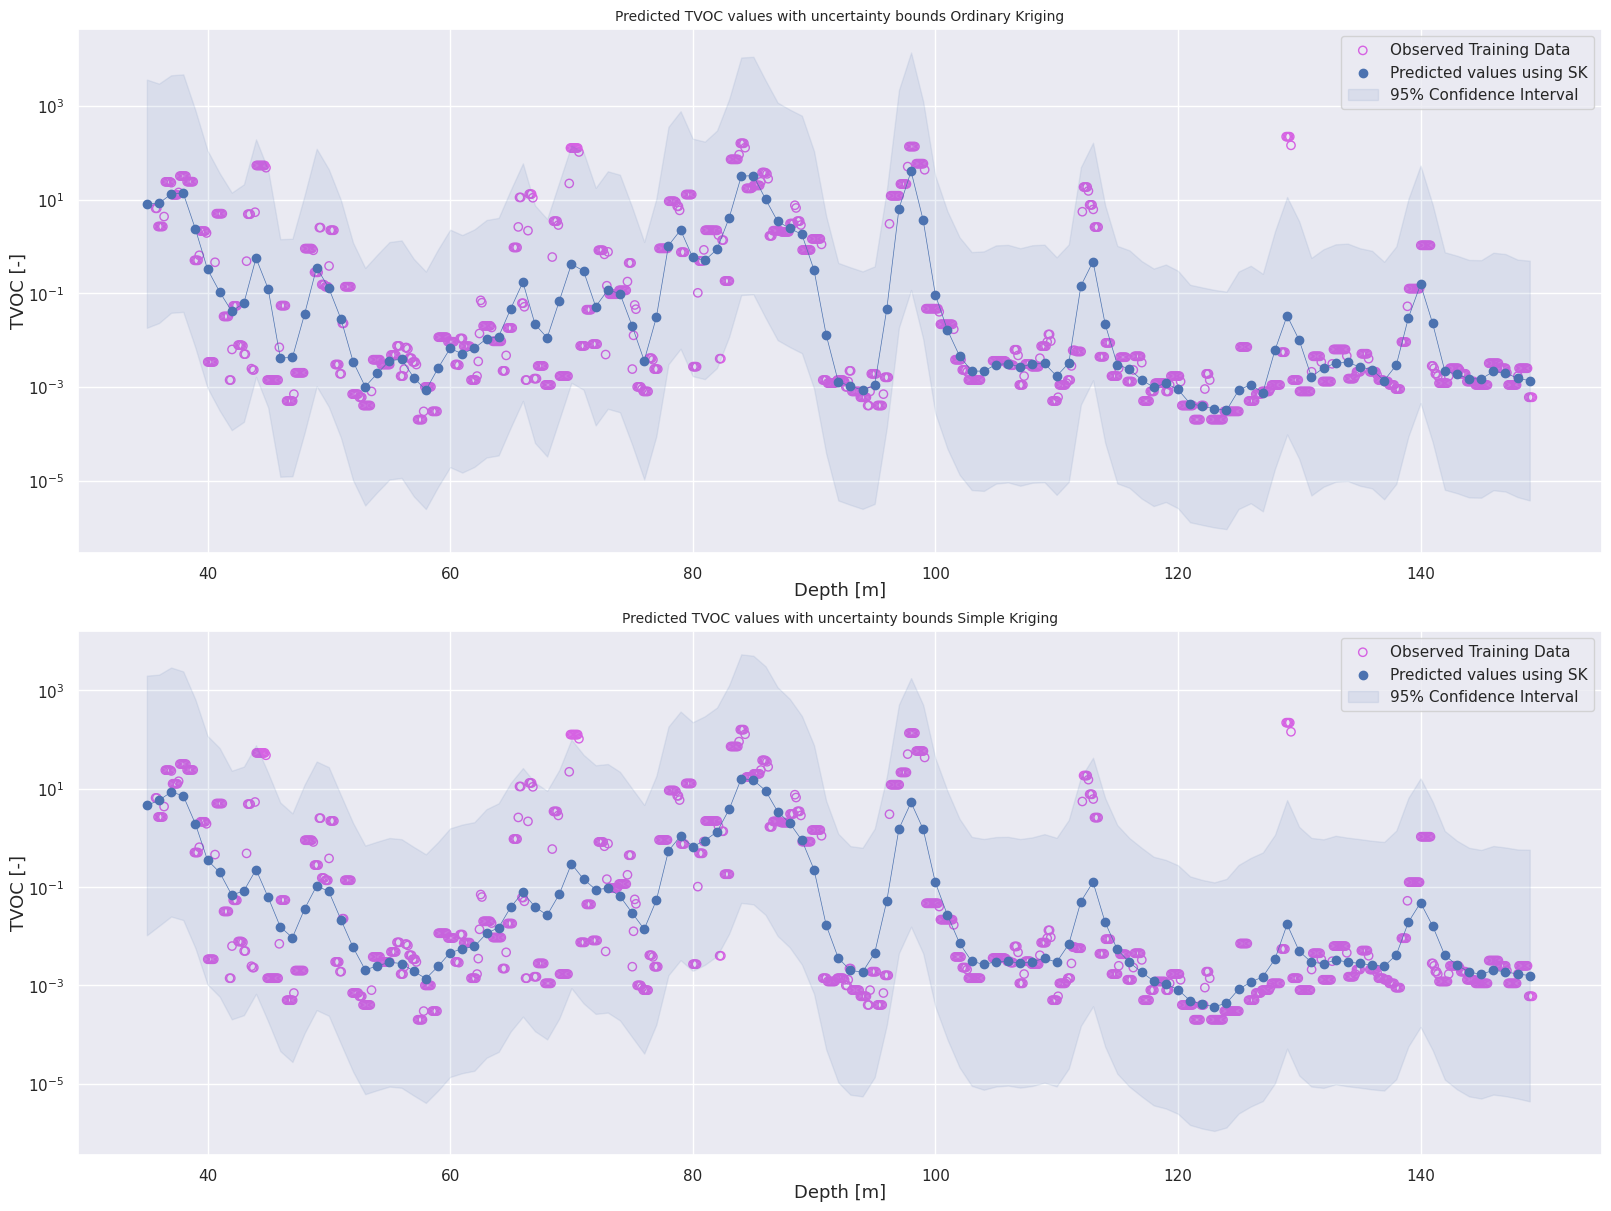

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), constrained_layout=True)

#Plot for ordinary kriging
ax1.scatter(depth_cleaned, TVOC ,  facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax1.scatter(x_pred_depth, TVOC_pred_ordinary , label='Predicted values using SK', c='b')
ax1.plot(x_pred_depth, TVOC_pred_ordinary,'b-', lw=0.5)

#Adding the uncertainty boundaries
ax1.fill_between(x_pred_depth.ravel(),
                np.exp(TVOC_pred_log_ordinary + 1.96 * np.sqrt(TVOC_var_log_ordinary)),
                np.exp(TVOC_pred_log_ordinary - 1.96 * np.sqrt(TVOC_var_log_ordinary)),
                color='b',
                label='95% Confidence Interval',
                alpha=0.1)

ax1.set_yscale('log')
ax1.set_title('Predicted TVOC values with uncertainty bounds Ordinary Kriging', fontsize= 10)

ax1.legend()
ax1.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax1.set_ylabel('TVOC [-]', fontsize=13, labelpad=0);

#Plot for simple kriging
ax2.scatter(depth_cleaned, TVOC ,  facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax2.scatter(x_pred_depth, TVOC_pred_simple , label='Predicted values using SK', c='b')
ax2.plot(x_pred_depth, TVOC_pred_simple,'b-', lw=0.5)

#Adding the uncertainty boundaries
ax2.fill_between(x_pred_depth.ravel(),
                np.exp(TVOC_pred_log_simple + 1.96 * np.sqrt(TVOC_var_log_simple)),
                np.exp(TVOC_pred_log_simple - 1.96 * np.sqrt(TVOC_var_log_simple)),
                color='b',
                alpha=0.1,
                label='95% Confidence Interval')

ax2.set_yscale('log')
ax2.set_title('Predicted TVOC values with uncertainty bounds Simple Kriging', fontsize= 10)
ax2.legend()
ax2.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax2.set_ylabel('TVOC [-]', fontsize=13, labelpad=0);



As can be seen above, the uncertainty for the simple kriging algorithm is smoother and does not jump that much to the outliers of the data. This means that this algorithm is less good in predicting values in these regions compared to the ordinary kriging algorithm. Both however capture the data quite well and the predicted values look quite accurate.

Now that both models have been proven to work, it is time to validate both these models so they can later be compared to gaussian processes.

# Validation

## Splitting the dataset

First, the data is split into "training" and test data. The test data is kept for the final model evaluation. The "training" data is split into k-folds, where each fold has the role of the validation data set once later in the k-fold cross validation loop. The selection of this data is done using the same seeds as with gaussian processes to make sure both models are fed the same data for each fold.

First, the split of the data into "training" and testset:

The length of the training set: 957 , the length of the test set: 170


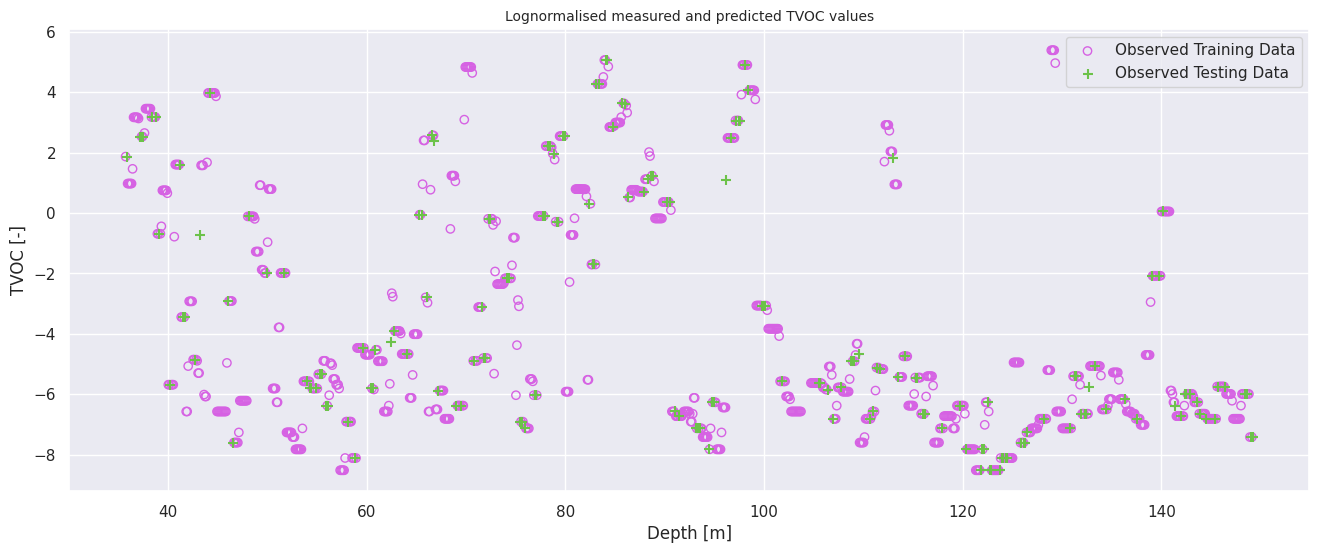

In [ ]:
#Split the data into a training set that can be fed into the k-fold algorithm for validation and the test set for the final model evaluation.
depth_train, depth_test, TVOC_train, TVOC_test = train_test_split(
    depth_cleaned, TVOC_log, test_size=0.15, random_state=0)

#Visualize the data split
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.scatter(depth_train,TVOC_train, facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")
ax.scatter(depth_test, TVOC_test, s=50, facecolors="#6CC24A", marker='+', label="Observed Testing Data")

ax.set_title('Lognormalised measured and predicted TVOC values', fontsize=10)
ax.set_ylabel('TVOC [-]')
ax.set_xlabel('Depth [m]')
ax.legend(loc='upper right');

print('The length of the training set:', len(TVOC_train), ', the length of the test set:', len(TVOC_test))

Now the "training" set can be split into folds, where each fold is used for validation once.

In [ ]:
# K-Fold validation from scratch, uncomment np.random.shuffle(index) to shuffle the indexes

#Specify fold size
n_folds = 10
fold_size = len(depth_train) // n_folds

#Use a random shuffle to shuffle the indices to randomize the dataset
index = np.arange(len(depth_train))
np.random.seed(0)
np.random.shuffle(index)

#start dividing the training data into k-folds
fold_index = []

for fold in range(n_folds):
  start = fold * fold_size
  end = (fold + 1) * fold_size
  # Specify validaton set each fold
  validation_index = index[start:end]
  # Data that is not in validation set, is training set for that
  train_index = index[~np.isin(index, validation_index)]
  fold_index.append([validation_index, train_index])

Now that all data has been divided properly, the best model can be found.

## Training and optimizing the model

For all hyperparameters located before, namely the type of variogram model, the number of closest points and the number of bins, an optimization loop has been run. Since the ordinary kriging algorithm only takes as input certain variogram models, it was chosen to focus on two types only: Exponential and Spherical.

The error terms used are the Mean Squared Error (MSE) and the Negative log validation density loss (NLVDL). In the loop, the best model and its parameters are saved for both ordinary and simple kriging.

In [ ]:
#Specify hyperparameters for loop
model_type = ['exponential', 'spherical']
N_closest_points = np.array([2, 10, 20, 30, 40, 50])
N_lags = np.array([6, 20, 40, 60, 80, 100])

#Set error terms to high values
MSE_best_ok = 10000
MSE_best_sk = 10000
NLVDL_best_ok = 10000
NLVDL_best_sk = 10000

#Allocate a variable for the models and parameters to be saved.
best_MSE_model_ok = ...
best_MSE_model_ok_params = []
best_MSE_model_sk = ...
best_MSE_model_sk_params = []
best_NLVDL_model_ok = ...
best_NLVDL_model_ok_params = []
best_NLVDL_model_sk = ...
best_NLVDL_model_sk_params = []

best_models_fold_ok_mse = []
best_models_fold_ok_nlvdl = []
best_models_fold_sk_mse = []
best_models_fold_sk_nlvdl = []

#loop through all the folds
for i in fold_index: # i[1] is training set, i[0] validation set
  #Select the training and validation set for the fold
  training_depth_fold = depth_train.iloc[i[1]]
  training_TVOC_fold = TVOC_train.iloc[i[1]]

  validation_depth_fold = depth_train.iloc[i[0]]
  validation_TVOC_fold = TVOC_train.iloc[i[0]]

  #Set error terms to high values for best fold models  
  best_MSE_fold_ok = 10000
  best_MSE_fold_sk = 10000
  best_NLVDL_fold_ok = 10000
  best_NLVDL_fold_sk = 10000

  #Parameter optimization
  for k in model_type:
    for j in N_closest_points:
      for l in N_lags:

          #Call the ordinary kriging algorithm on the training set of the fold
          ok = OrdinaryKriging(training_depth_fold,
                    np.zeros(len(training_depth_fold)),
                    training_TVOC_fold,
                    variogram_model= k,
                    nlags = int(l))

          #Calculate error term for ordinary kriging
          #First predict on the validation set
          TVOC_pred_log, TVOC_var_log = ok.execute('grid', validation_depth_fold, 0, backend='loop', n_closest_points = j)
          TVOC_pred_log = np.squeeze(TVOC_pred_log)
          TVOC_var_log = np.squeeze(TVOC_var_log)

          #Then calculate different error terms
          difference_ord = np.abs(TVOC_pred_log - validation_TVOC_fold)
          MSE_ord = 1/len(TVOC_pred_log) * np.sum(difference_ord**2)
          MAE_ord = np.sum(difference_ord)
          NLVDL_ord = np.sum(-0.5 * np.log(TVOC_var_log) - (validation_TVOC_fold - TVOC_pred_log)**2 / (2 * TVOC_var_log) - 0.5 * np.log(2 * np.pi))

          #Update the best model selection
          if MSE_ord < MSE_best_ok:
            MSE_best_ok = MSE_ord
            best_MSE_model_ok = ok
            best_MSE_model_ok_params = [k, j, l]

          if MSE_ord < best_MSE_fold_ok:
            best_MSE_fold_ok = MSE_ord

          if NLVDL_ord < NLVDL_best_ok:
            NLVDL_best_ok = NLVDL_ord
            best_NLVDL_model_ok = ok
            best_NLVDL_model_ok_params = [k, j, l]

          if NLVDL_ord < best_NLVDL_fold_ok:
            best_NLVDL_fold_ok = NLVDL_ord

    #Optimize the simple kriging algorithm
    if k == 'exponential':
      cov_model = Exponential(dim=1, var=np.std(cond_val)**2, nugget=1e-8)

    if k == 'spherical':
      cov_model = Spherical(dim=1, var=np.std(cond_val)**2, nugget=1e-8)

    #Call the simple kriging algorithm on the training set of the fold
    krig = krige.Simple(cov_model, mean=np.mean(training_TVOC_fold), cond_pos=training_depth_fold, cond_val=training_TVOC_fold, fit_variogram=True)

    #Calculate error term for simple kriging
    #First predict on the validation set
    TVOC_pred_log_simple, TVOC_var_log_simple = krig(validation_depth_fold)

    #Then calculate different error terms
    difference_simple = np.abs(TVOC_pred_log_simple - validation_TVOC_fold)
    MSE_simple = 1/len(TVOC_pred_log_simple) * np.sum(difference_simple**2)
    MAE_simple = np.sum(difference_simple)
    NLVDL_simple = np.sum(-0.5 * np.log(TVOC_var_log_simple) - (validation_TVOC_fold - TVOC_pred_log_simple)**2 / (2 * TVOC_var_log_simple) - 0.5 * np.log(2 * np.pi))

    #Update the best model selection
    if MSE_simple < MSE_best_sk:
      MSE_best_sk = MSE_simple
      best_MSE_model_sk = krig
      best_MSE_model_sk_params = [k]

    if MSE_simple < best_MSE_fold_sk:
      best_MSE_fold_sk = MSE_simple

    if NLVDL_simple < NLVDL_best_sk:
      NLVDL_best_sk = NLVDL_simple
      best_NLVDL_model_sk = krig
      best_NLVDL_model_sk_params = [k]

    if NLVDL_simple < best_NLVDL_fold_sk:
      best_NLVDL_fold_sk = NLVDL_simple

  #Add all best MSE and NLVDL values for the fold to the list  
  best_models_fold_ok_mse.append(best_MSE_fold_ok)
  best_models_fold_ok_nlvdl.append(best_NLVDL_fold_ok)
  best_models_fold_sk_mse.append(best_MSE_fold_sk)
  best_models_fold_sk_nlvdl.append(best_NLVDL_fold_sk)


## Evaluating error terms after validation

Inside the optimization loop, for every fold the lowest MSE value for all configurations was saved to see the spread in the MSE and NLVDL error terms based on all model configurations. This indicates how much effect these parameters had on the error for the validation data per fold. 

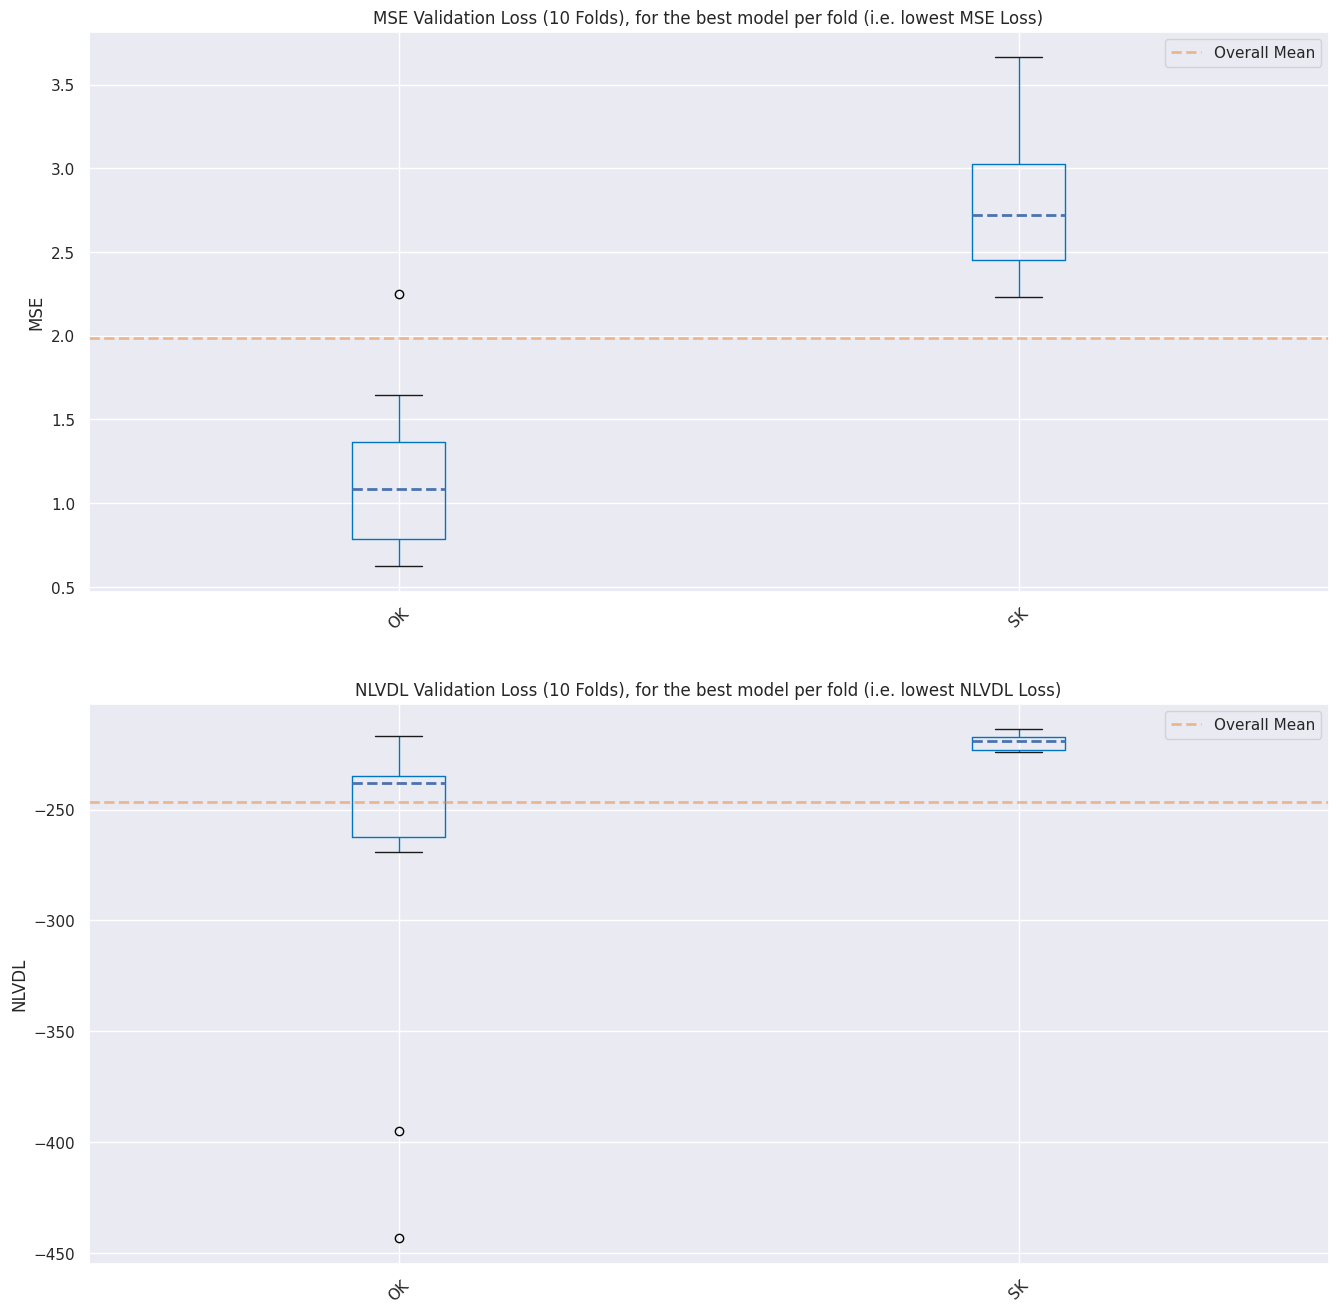

In [ ]:
# Convert to pandas DataFrames
mse_df = pd.DataFrame({'OK': best_models_fold_ok_mse, 'SK': best_models_fold_sk_mse})
nlvdl_df = pd.DataFrame({'OK': best_models_fold_ok_nlvdl, 'SK': best_models_fold_sk_nlvdl})

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,16))

median_properties = {
    'color': 'b',
    'linestyle': '--',
    'linewidth': 2
}

boxplot_positions = [pos for pos in range(2)]
mse_df.boxplot(ax=ax1, medianprops=median_properties, rot=45, positions=boxplot_positions)
nlvdl_df.boxplot(ax=ax2, medianprops=median_properties, rot=45, positions=boxplot_positions)

# Calculate mean values per column
mean_values_mse = mse_df.mean().tolist()
mean_values_nlvdl = nlvdl_df.mean().tolist()

# Calculate the overall mean of mean values
overall_mean_mse = np.mean(mean_values_mse)
overall_mean_nlvdl = np.mean(mean_values_nlvdl)

# # Plot a mean line across all items
ax1.axhline(y=overall_mean_mse, color='#eb8334', alpha=0.5, linestyle='--', linewidth=2, label='Overall Mean')
ax1.set_title(f'MSE Validation Loss ({n_folds} Folds), for the best model per fold (i.e. lowest MSE Loss)')
ax1.set_ylabel('MSE')
ax1.legend(loc='upper right')

ax2.axhline(y=overall_mean_nlvdl, color='#eb8334', alpha=0.5, linestyle='--', linewidth=2, label='Overall Mean')
ax2.set_title(f'NLVDL Validation Loss ({n_folds} Folds), for the best model per fold (i.e. lowest NLVDL Loss)')
ax2.set_ylabel('NLVDL')
ax2.legend(loc='upper right');

As can be seen, the configurations of the model have only a small influence on both the ordinary and simple kriging algorithm. The MSE seems to stay in the same range for both algorithms.  The NLVDL term however especially in ordinary kriging was very influenced by the choice of hyperparameters. Likely 2 of the folds resulted in the outlier terms, where probably a large part of the peaks was selected or most of the lower values in the data. Therefore, when validating this resulted in a bad fit.

# Evaluating the model

Now that the best model was selected and the hyperparameters are calibrated, predictions were made on the previously defined test set that the model has not seen before. The MSE and NLVDL error terms were calculated on the predictions for both the model optimized on the MSE error and on the NLVDL error. The table summarizing the most important values for the later comparison with gaussian processes can be seen below.

In [ ]:
#Ordinary kriging
#Isolate the best ordinary kriging models for both error types
model_type_mse, close_points_mse, n_lags_mse = best_MSE_model_ok_params
model_type_nlvdl, close_points_nlvdl, n_lags_nlvdl = best_NLVDL_model_ok_params

#Make predictions on the test-dataset
TVOC_pred_log_mse, TVOC_var_log_mse = best_MSE_model_ok.execute('grid', depth_test, 0, backend='loop', n_closest_points = close_points_mse)
TVOC_pred_log_mse = np.squeeze(TVOC_pred_log_mse)
TVOC_var_log_mse = np.squeeze(TVOC_var_log_mse)

TVOC_pred_log_nlvdl, TVOC_var_log_nlvdl = best_NLVDL_model_ok.execute('grid', depth_test, 0, backend='loop', n_closest_points = close_points_nlvdl)
TVOC_pred_log_nlvdl = np.squeeze(TVOC_pred_log_nlvdl)
TVOC_var_log_nlvdl = np.squeeze(TVOC_var_log_nlvdl)

#Calculate error terms ok based on MSE prediction
difference_ord_mse = np.abs(TVOC_pred_log_mse - TVOC_test)
MSE_ord_mse = 1/len(TVOC_pred_log_mse) * np.sum(difference_ord_mse**2)
MAE_ord_mse = np.sum(difference_ord_mse)
NLVDL_ord_mse = np.sum(-0.5 * np.log(TVOC_var_log_mse) - (TVOC_test - TVOC_pred_log_mse)**2 / (2 * TVOC_var_log_mse) - 0.5 * np.log(2 * np.pi))

#Calculate error terms ok based on NLVDL prediction
difference_ord_nlvdl = np.abs(TVOC_pred_log_nlvdl - TVOC_test)
MSE_ord_nlvdl = 1/len(TVOC_pred_log_nlvdl) * np.sum(difference_ord_nlvdl**2)
MAE_ord_nlvdl = np.sum(difference_ord_nlvdl)
NLVDL_ord_nlvdl = np.sum(-0.5 * np.log(TVOC_var_log_nlvdl) - (TVOC_test - TVOC_pred_log_nlvdl)**2 / (2 * TVOC_var_log_nlvdl) - 0.5 * np.log(2 * np.pi))

In [ ]:
#Simple kriging
#Isolate the best simple kriging models for both error types
model_type_mse_sk = best_MSE_model_sk_params
model_type_nlvdl_sk = best_NLVDL_model_sk_params

#Make predictions on the test-dataset
TVOC_pred_log_simple_mse, TVOC_var_log_simple_mse = best_MSE_model_sk(depth_test)
TVOC_pred_log_simple_nlvdl, TVOC_var_log_simple_nlvdl = best_NLVDL_model_sk(depth_test)

#Calculate error terms sk based on MSE prediction
difference_simple_mse = np.abs(TVOC_pred_log_simple_mse - TVOC_test)
MSE_simple_mse = 1/len(TVOC_pred_log_simple_mse) * np.sum(difference_simple_mse**2)
MAE_simple_mse = np.sum(difference_simple_mse)
NLVDL_simple_mse = np.sum(-0.5 * np.log(TVOC_var_log_simple_mse) - (TVOC_test - TVOC_pred_log_simple_mse)**2 / (2 * TVOC_var_log_simple_mse) - 0.5 * np.log(2 * np.pi))

#Calculate error terms sk based on NLVDL prediction
difference_simple_nlvdl = np.abs(TVOC_pred_log_simple_nlvdl - TVOC_test)
MSE_simple_nlvdl = 1/len(TVOC_pred_log_simple_nlvdl) * np.sum(difference_simple_nlvdl**2)
MAE_simple_nlvdl = np.sum(difference_simple_nlvdl)
NLVDL_simple_nlvdl = np.sum(-0.5 * np.log(TVOC_var_log_simple_nlvdl) - (TVOC_test - TVOC_pred_log_simple_nlvdl)**2 / (2 * TVOC_var_log_simple_nlvdl) - 0.5 * np.log(2 * np.pi))

In [ ]:
print("Best Performance based on MSE:")
table_mse = PrettyTable()
table_mse.field_names = ["Model", "MSE (on test data)", "Kernel Parameters"]
table_mse.align["Model"] = "l"  # Left-align the "Model" column
table_mse.align["Kernel Parameters"] = "r"  # Right-align the "Error" column
table_mse.add_row(['Optimized on MSE (OK)',f"{MSE_ord_mse:.2f}", 
                    f"Model type={model_type_mse}, Nr_closest_points={close_points_mse}, n_lags={n_lags_mse:.2f}"])
table_mse.add_row(['Optimized on MSE (SK)',f"{MSE_simple_mse:.2f}", f"Model type={model_type_mse_sk}"])                    
print(table_mse)

print("Best Performance based on NLVDL:")
table_nlvdl = PrettyTable()
table_nlvdl.field_names = ["Model", "NLVDL (on test data)", "Kernel Parameters"]
table_nlvdl.align["Model"] = "l"  # Left-align the "Model" column
table_nlvdl.align["Kernel Parameters"] = "r"  # Right-align the "Error" column
table_nlvdl.add_row(['Optimized on NLVDL (OK)',f"{NLVDL_ord_nlvdl:.2f}", 
                    f"Model type={model_type_nlvdl}, Nr_closest_points={close_points_nlvdl}, n_lags={n_lags_nlvdl:.2f}"])
table_nlvdl.add_row(['Optimized on NLVDL (SK)',f"{NLVDL_simple_nlvdl:.2f}", f"Model type={model_type_nlvdl_sk}"])                    
print(table_nlvdl)

Best Performance based on MSE:
+-----------------------+--------------------+-----------------------------------------------------------+
| Model                 | MSE (on test data) |                                         Kernel Parameters |
+-----------------------+--------------------+-----------------------------------------------------------+
| Optimized on MSE (OK) |        0.80        | Model type=exponential, Nr_closest_points=10, n_lags=6.00 |
| Optimized on MSE (SK) |        2.00        |                                Model type=['exponential'] |
+-----------------------+--------------------+-----------------------------------------------------------+
Best Performance based on NLVDL:
+-------------------------+----------------------+-----------------------------------------------------------+
| Model                   | NLVDL (on test data) |                                         Kernel Parameters |
+-------------------------+----------------------+----------------------

As can be seen, the error terms for ordinary kriging are slightly less than those of simple kriging. Indicating that the first algorithm has the best performance on this dataset. The performance of both algorithms is plotted further below. It is also visible that depending on the error term chosen for optimalisation, a different model type in simple kriging and a different number of closest_points in ordinary kriging was chosen.

Likely the ordinary krigging model is way more sensitive to the sudden peaks in the data, causing it to take the lowest amount of closest points into account. What also is of interest is that for both error terms the minimum number of lags is selected and therefore the minimum number of bins. It could be said that this might not be very accurate, or there are multiple scales of variability present in the data. This could be interesting to look at as a further recommendation.

Now that these values are obtained, the MSE and NLVDL for the test data can be added to the previous boxplot as well. This is done in the next bit of code.

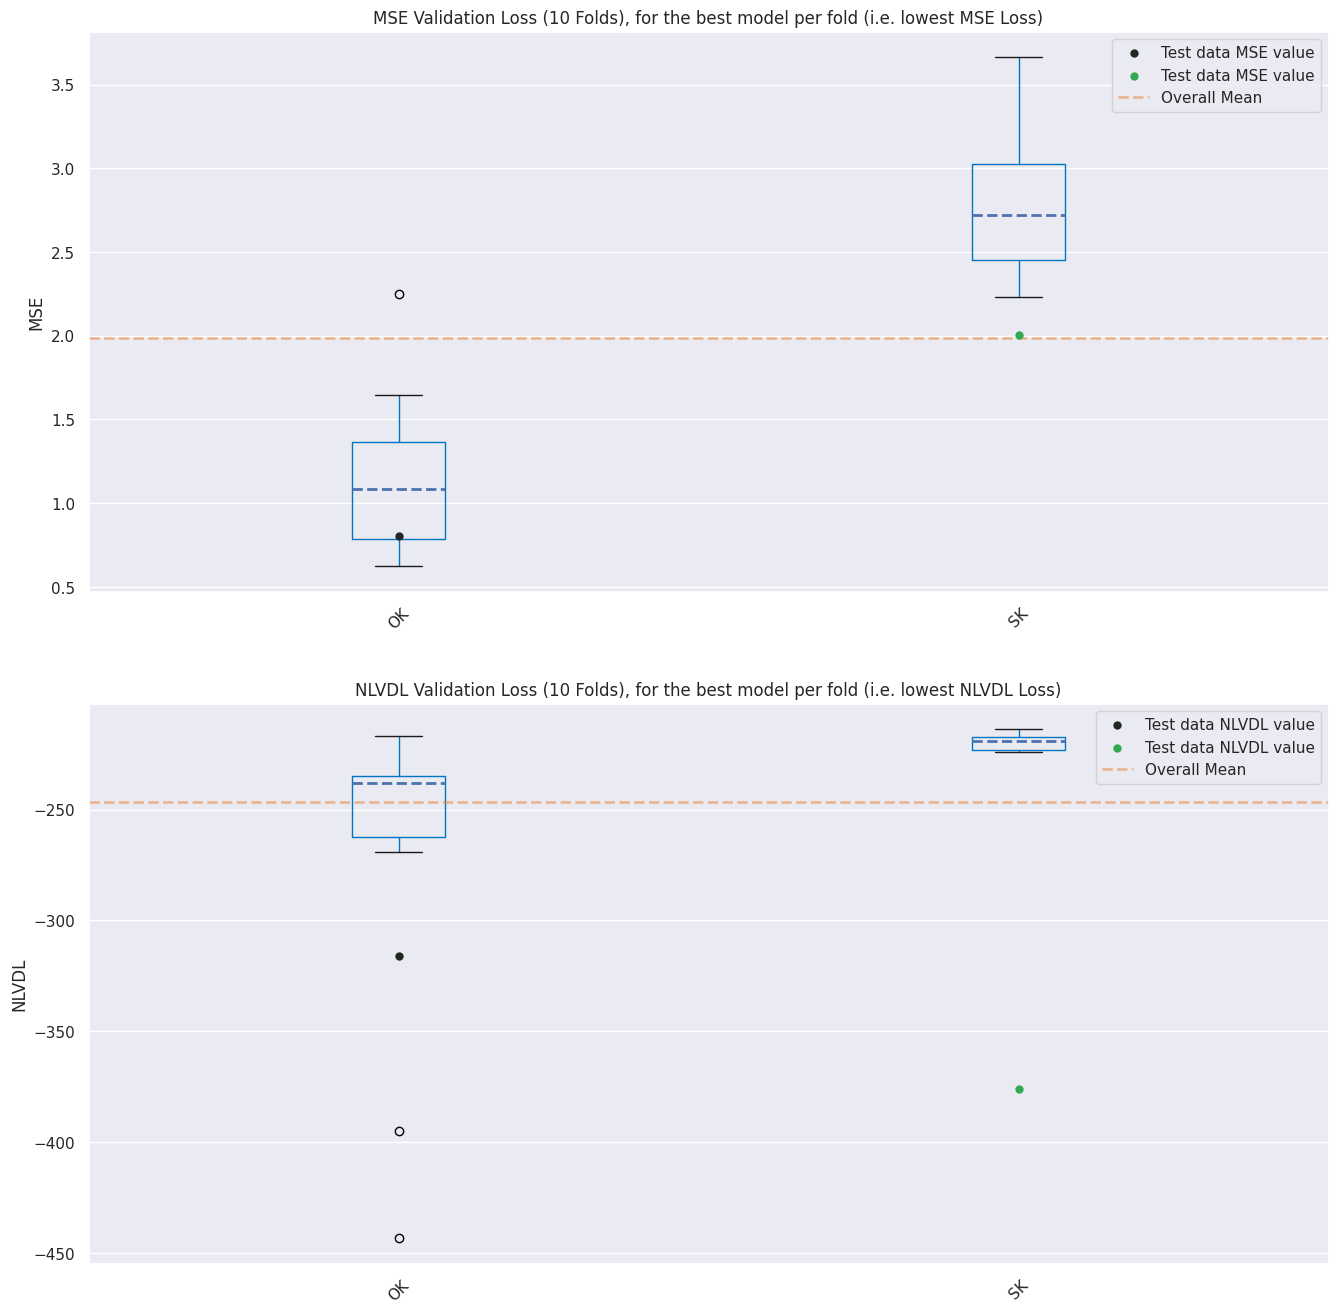

In [ ]:
mse_test_df = pd.DataFrame({'OK': [MSE_ord_mse], 'SK': [MSE_simple_mse]})
nlvdl_test_df = pd.DataFrame({'OK': [NLVDL_ord_nlvdl], 'SK': [NLVDL_simple_nlvdl]})

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,16))

median_properties = {
    'color': 'b',
    'linestyle': '--',
    'linewidth': 2
}

boxplot_positions = [pos for pos in range(2)]
mse_df.boxplot(ax=ax1, medianprops=median_properties, rot=45, positions=boxplot_positions)
nlvdl_df.boxplot(ax=ax2, medianprops=median_properties, rot=45, positions=boxplot_positions)

sns.stripplot(ax=ax1, data=mse_test_df, jitter=True, marker='o', s=6, color='#32a852', label='Test data MSE value')

sns.stripplot(ax=ax2, data=nlvdl_test_df, jitter=True, marker='o', s=6, color='#32a852', label='Test data NLVDL value')


# Calculate mean values per column
mean_values_mse = mse_df.mean().tolist()
mean_values_nlvdl = nlvdl_df.mean().tolist()

# Calculate the overall mean of mean values
overall_mean_mse = np.mean(mean_values_mse)
overall_mean_nlvdl = np.mean(mean_values_nlvdl)

# # Plot a mean line across all items
ax1.axhline(y=overall_mean_mse, color='#eb8334', alpha=0.5, linestyle='--', linewidth=2, label='Overall Mean')
ax1.set_title(f'MSE Validation Loss ({n_folds} Folds), for the best model per fold (i.e. lowest MSE Loss)')
ax1.set_ylabel('MSE')
ax1.legend(loc='upper right')

ax2.axhline(y=overall_mean_nlvdl, color='#eb8334', alpha=0.5, linestyle='--', linewidth=2, label='Overall Mean')
ax2.set_title(f'NLVDL Validation Loss ({n_folds} Folds), for the best model per fold (i.e. lowest NLVDL Loss)')
ax2.set_ylabel('NLVDL')
ax2.legend(loc='upper right');

It can be seen that as expected the error terms of the fit on the test data are outside the plot with the validation data. This is highly dependent on the exact test data set that was acquired since the data varies considerably over depth and not all peaks could be present in the random selection, causing the final model to poorly fit those datapoints. For ordinary kriging the MSE of the test data falls into the same range as before during the k-fold cross validation. For simple kriging however, the model has performed better on the test data. This could be related to the selection of the testing dataset as described before. In this case, likely more data close to the mean was selected as test data, causing a better interpolation for the simple kriging algorithm.

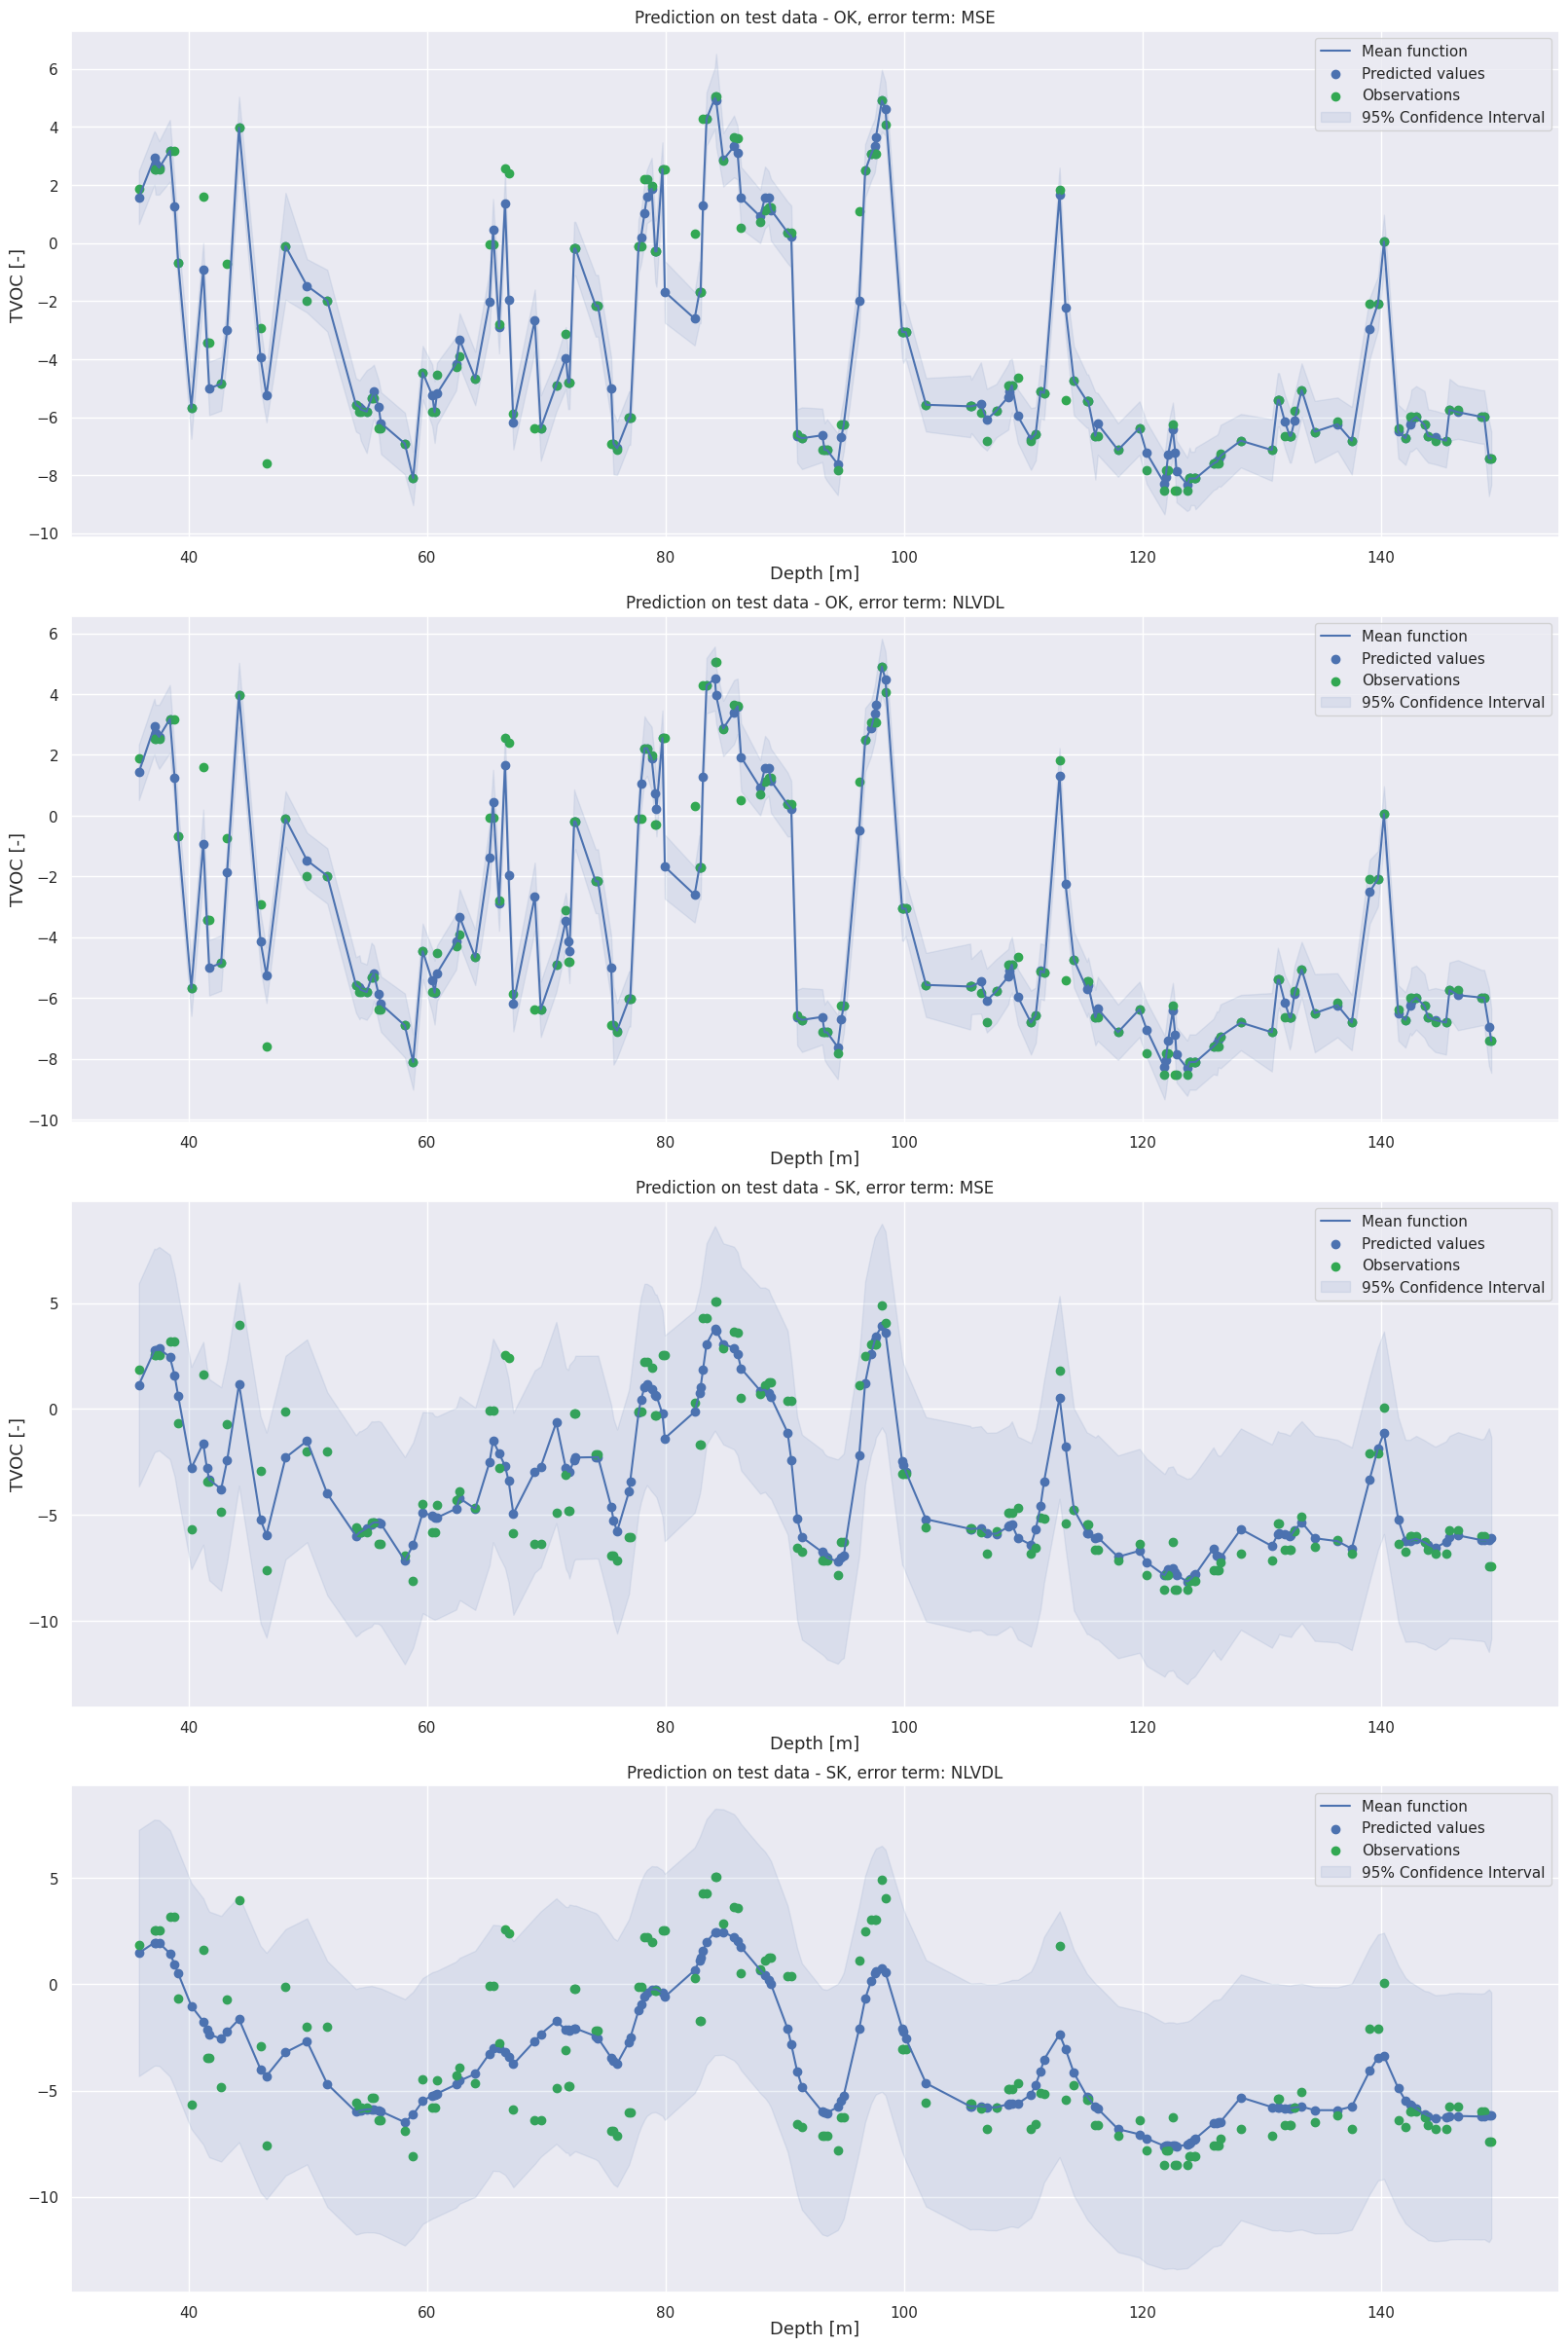

In [ ]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, figsize=(16, 24), constrained_layout=True)

#Ordinary kriging based on MSE
TVOC_depth_mse = np.array(list(zip(TVOC_pred_log_mse, depth_test)))
sorted_TVOC_depth_mse = TVOC_depth_mse[TVOC_depth_mse[:, 1].argsort()]
ax1.plot(sorted_TVOC_depth_mse[:, 1], sorted_TVOC_depth_mse[:, 0], 'b-', label='Mean function')
ax1.scatter(depth_test, TVOC_pred_log_mse, label='Predicted values', c='b')
ax1.scatter(depth_test, TVOC_test, marker='o', color='#32a852', label='Observations')
ax1.fill_between(sorted_TVOC_depth_mse[:, 1],
                (sorted_TVOC_depth_mse[:, 0] + 1.96 * np.sqrt(TVOC_var_log_mse)),
                (sorted_TVOC_depth_mse[:, 0] - 1.96 * np.sqrt(TVOC_var_log_mse)),
                color='b',
                label='95% Confidence Interval',
                alpha=0.1)

ax1.set_title('Prediction on test data - OK, error term: MSE')
ax1.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax1.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax1.legend(loc='upper right');

#Simple kriging based on MSE
TVOC_depth_mse_sk = np.array(list(zip(TVOC_pred_log_simple_mse, depth_test)))
sorted_TVOC_depth_mse_sk = TVOC_depth_mse_sk[TVOC_depth_mse_sk[:, 1].argsort()]
ax3.plot(sorted_TVOC_depth_mse_sk[:, 1], sorted_TVOC_depth_mse_sk[:, 0], 'b-', label='Mean function')
ax3.scatter(depth_test, TVOC_pred_log_simple_mse, label='Predicted values', c='b')
ax3.scatter(depth_test, TVOC_test, marker='o', color='#32a852', label='Observations')
ax3.fill_between(sorted_TVOC_depth_mse_sk[:, 1],
                (sorted_TVOC_depth_mse_sk[:, 0] + 1.96 * np.sqrt(TVOC_var_log_simple_mse)),
                (sorted_TVOC_depth_mse_sk[:, 0] - 1.96 * np.sqrt(TVOC_var_log_simple_mse)),
                color='b',
                label='95% Confidence Interval',
                alpha=0.1)

ax3.set_title('Prediction on test data - SK, error term: MSE')
ax3.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax3.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax3.legend(loc='upper right');

#Ordinary kriging based on NLVDL
TVOC_depth_nlvdl = np.array(list(zip(TVOC_pred_log_nlvdl, depth_test)))
sorted_TVOC_depth_nlvdl = TVOC_depth_nlvdl[TVOC_depth_nlvdl[:, 1].argsort()]
ax2.plot(sorted_TVOC_depth_nlvdl[:, 1], sorted_TVOC_depth_nlvdl[:, 0], 'b-', label='Mean function')
ax2.scatter(depth_test, TVOC_pred_log_nlvdl, label='Predicted values', c='b')
ax2.scatter(depth_test, TVOC_test, marker='o', color='#32a852', label='Observations')
ax2.fill_between(sorted_TVOC_depth_nlvdl[:, 1],
                (sorted_TVOC_depth_nlvdl[:, 0] + 1.96 * np.sqrt(TVOC_var_log_nlvdl)),
                (sorted_TVOC_depth_nlvdl[:, 0] - 1.96 * np.sqrt(TVOC_var_log_nlvdl)),
                color='b',
                label='95% Confidence Interval',
                alpha=0.1)


ax2.set_title('Prediction on test data - OK, error term: NLVDL')
ax2.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax2.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax2.legend(loc='upper right');

#Simple kriging based on NLVDL
TVOC_depth_nlvdl_sk = np.array(list(zip(TVOC_pred_log_simple_nlvdl, depth_test)))
sorted_TVOC_depth_nlvdl_sk = TVOC_depth_nlvdl_sk[TVOC_depth_nlvdl_sk[:, 1].argsort()]
ax4.plot(sorted_TVOC_depth_nlvdl_sk[:, 1], sorted_TVOC_depth_nlvdl_sk[:, 0], 'b-', label='Mean function')
ax4.scatter(depth_test, TVOC_pred_log_simple_nlvdl, label='Predicted values', c='b')
ax4.scatter(depth_test, TVOC_test, marker='o', color='#32a852', label='Observations')
ax4.fill_between(sorted_TVOC_depth_nlvdl_sk[:, 1],
                (sorted_TVOC_depth_nlvdl_sk[:, 0] + 1.96 * np.sqrt(TVOC_var_log_simple_nlvdl)),
                (sorted_TVOC_depth_nlvdl_sk[:, 0] - 1.96 * np.sqrt(TVOC_var_log_simple_nlvdl)),
                color='b',
                label='95% Confidence Interval',
                alpha=0.1)

ax4.set_title('Prediction on test data - SK, error term: NLVDL')
ax4.set_xlabel('Depth [m]', fontsize=13, labelpad=0)
ax3.set_ylabel('TVOC [-]', fontsize=13, labelpad=0)
ax4.legend(loc='upper right');

As can be seen above, the predictions done with ordinary kriging have less uncertainty than the predictions done with simple kriging on the same test set. This is likely because the ordinary kriging method takes into account only the datapoints that are close to the location of the prediction and highly correlated, making it easier to make better predictions for this data. The simple kriging algorithm stays closer to the mean, since it always uses the entire dataset for prediction and is not able to capture the high peaks of the data well. Therefore this results in a higher uncertainty.

The next plots compare the predicted data to the test data to visualize in a different way how well the algorithm performed.

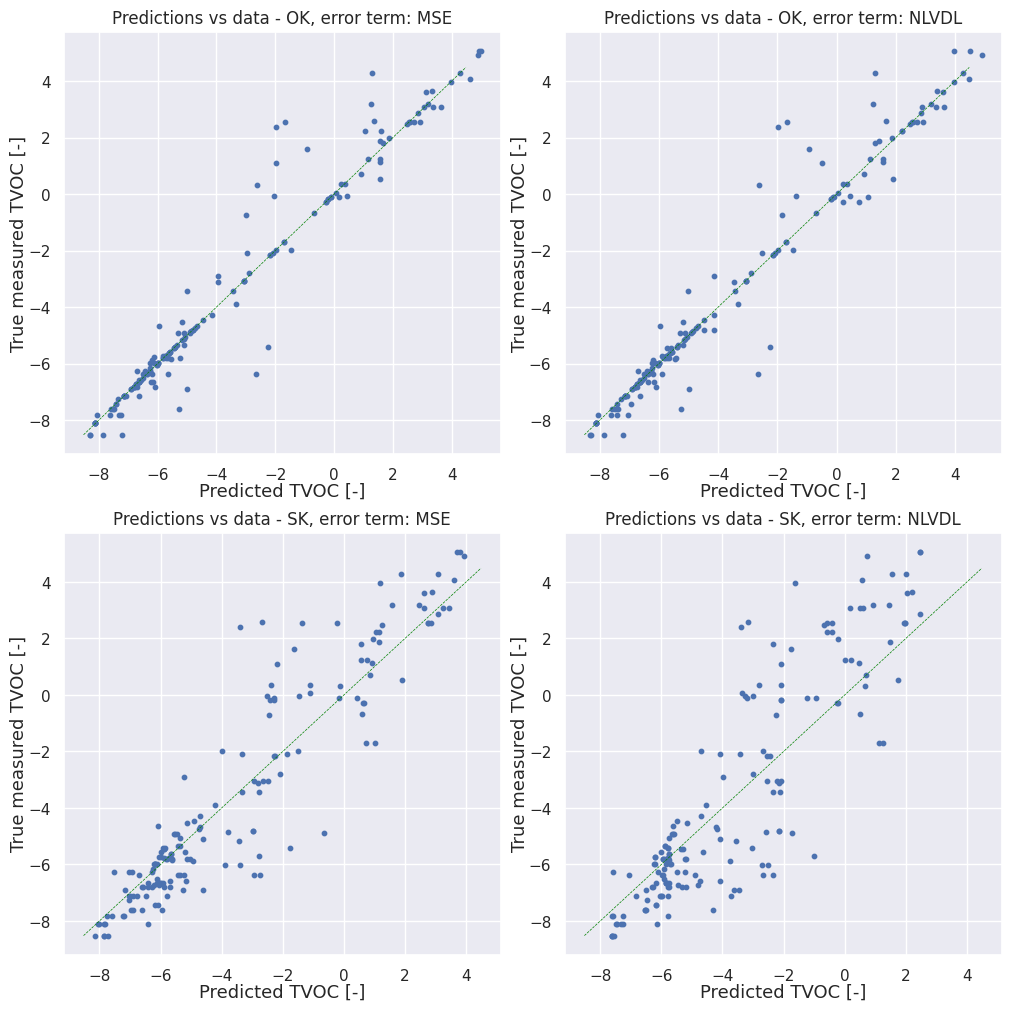

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
reference_line = np.arange(np.min(TVOC_test), np.max(TVOC_test))

ax1.plot(reference_line, reference_line, color='green', linestyle='dashed', lw=0.5)
ax1.scatter(TVOC_pred_log_mse, TVOC_test, label='Predicted values', s= 10, c='b')
ax1.set_title('Predictions vs data - OK, error term: MSE')
ax1.set_xlabel('Predicted TVOC [-]', fontsize=13, labelpad=0)
ax1.set_ylabel('True measured TVOC [-]', fontsize=13, labelpad=0)

ax3.plot(reference_line, reference_line, color='green', linestyle='dashed', lw=0.5)
ax3.scatter(TVOC_pred_log_simple_mse, TVOC_test, label='Predicted values', s= 10, c='b')
ax3.set_title('Predictions vs data - SK, error term: MSE')
ax3.set_xlabel('Predicted TVOC [-]', fontsize=13, labelpad=0)
ax3.set_ylabel('True measured TVOC [-]', fontsize=13, labelpad=0)

ax2.plot(reference_line, reference_line, color='green', linestyle='dashed', lw=0.5)
ax2.scatter(TVOC_pred_log_nlvdl, TVOC_test, label='Predicted values', s= 10, c='b')
ax2.set_title('Predictions vs data - OK, error term: NLVDL')
ax2.set_xlabel('Predicted TVOC [-]', fontsize=13, labelpad=0)
ax2.set_ylabel('True measured TVOC [-]', fontsize=13, labelpad=0)

ax4.plot(reference_line, reference_line, color='green', linestyle='dashed', lw=0.5)
ax4.scatter(TVOC_pred_log_simple_nlvdl, TVOC_test, label='Predicted values', s= 10, c='b')
ax4.set_title('Predictions vs data - SK, error term: NLVDL')
ax4.set_xlabel('Predicted TVOC [-]', fontsize=13, labelpad=0)
ax4.set_ylabel('True measured TVOC [-]', fontsize=13, labelpad=0);


The same conclusions can be drawn here as from the previous plot. Ordinary kriging performs better than simple kriging. There clearly is more uncertainty involved in the simple kriging algorithm.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=43f1d11b-db76-4626-91af-712e5d84d518' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>